# **Drifting assemblies in networks of LIF neurons**
Yaroslav Felipe Kalle Kossio, Sven Goedeke, Christian Klos, and Raoul-Martin Memmesheimer

*Neural Network Dynamics and Computation, Institute of Genetics, University of Bonn, Germany.*

---

This notebook contains example code to create a network of LIF neurons with three drifting assemblies (see corresponding section and Fig. 2 in the manuscript). The network simulation is done using the Brian 2 simulator. With a recent desktop processor a simulation of 20 hours network time should take about 20 hours. After this the assembly structure is completely or almost completely reshuffled with respect to the initial structure. Reordering the weight matrices with the help of a community detection algorithm (Louvain algorithm from the brain connectivity toolbox bctpy) reveals that the assembly structure persists.

To illustrate assembly drift the simulation time is set to 15 mins during which first switches of neurons between the assemblies can be observed (see plots of the weight matrices during the simulation).

# Import dependencies

In [1]:
import bct
import matplotlib.pyplot as plt
import numpy as np
from brian2 import *
from brian2.synapses.synapses import SynapticIndexing
from tqdm import tqdm  # Alternatively use: from tqdm.notebook import tqdm

# Parameters

Parameter | Symbol in the paper | Explanation
--- | --- | ---
`t_sim` | - | Simulation time
`asbly_n` | - | Number of assemblies
`N_peri` | $N_\text{peri}$ | Number of periphery neurons per assembly
`N_p` | - | Number of periphery neurons
`N_e` | $N_E$ | Number of excitatory neurons
`N_i` | $N_I$ | Number of inhibitory neurons
`p_int` | $p_\text{int}$ | Connection density between interior neurons
`p_peri` | $p_\text{peri}$ | Connection density between interior and periphery neurons
`asbly_size` | - | Initial size of assemblies including periphery neurons
`tau_m` | $\tau_m$ | Membrane time constant
`v_0` | $V_0$ | Reset potential
`v_th` | $V_\vartheta$ | Spike threshold
`v_r` | $V_\text{rest}$ | Resting potential
`t_ref` | $\tau_\text{ref}$ | Refractory period
`sigma` | $\sqrt{2}\sigma$ | Standard deviation of potential noise
`tau_e` | $\tau_E$ | Time constant of excitatory currents
`tau_i` | $\tau_I$ | Time constant of inhibitory currents
`W_e_sum` | $w_\text{max}$ | Sum of exc. input and output to int. neurons
`W_p_sum` | $w_\text{max,pc}$ | Sum of exc. input and output to peri. neurons
`tau_p` | $\tau_\text{LTP}$ | Potentiation time constant
`tau_d` | $\tau_\text{LTD}$ | Depression time constant
`STDP_peak` | $\eta$ | STDP peak
`turnover_tau` | $L_\text{int}$, $L_\text{peri}$ | Life time of synapses that turn over

In [2]:
## Network
t_sim = 15 * 60 * second #20 * 60 * 60 * second  # simulation time
asbly_n = 3  # number of assemblies
N_peri = 4  # periphery neurons per assembly
N_p = asbly_n * N_peri  # periphery neurons
N_e = 102  # excitatory neurons
N_i = int(N_e / 5)  # inhibitory neurons
p_int = 1  # connection probability between interior neurons
p_peri = 1  # connection probability between interior and periphery neurons
asbly_size = int(N_e / asbly_n)  # initial size of assemblies including periphery neurons


## Neuron
tau_m = 10 * ms  # membrane time constant
v_0 = 0 * mV  # reset potential
v_th = 20 * mV  # threshold
v_r = 10 * mV  # resting potential
t_ref = 5 * ms  # absolute refactory period
sigma = np.sqrt(2) * 3.5 * mV  # noise amplitude, sqrt(2) * STD of OU-Process


## Synapses
tau_e = 2 * ms  # time constant of excitatory currents
tau_i = 5 * ms  # time constant of inhibitory currents
w_e_max = 12.5 * mV  # max weight int->int
w_p_max = 3 * w_e_max  # max weight int->peri, peri->int
# sum of excitatory input and output weight to interior neurons
W_e_sum = (
    1 / 2 * ((asbly_size - N_peri - 1) * p_int * w_e_max + N_peri * p_peri * w_p_max)
) 
# sum of excitatory input and output weight to periphery neurons
W_p_sum = 1 / 5 * (asbly_size - N_peri) * p_peri * w_p_max  
W_i_sum = - W_e_sum * tau_e / tau_i  # sum of inh. input
 # conversion factor from weight to EPSP amplitude
w_to_epsp = (tau_e/tau_m) ** (tau_m / (tau_m - tau_e))


## STDP
tau_p = 20 * ms  # potentiation time constant
tau_d = 40 * ms  # depression time constant
STDP_delta = -1  # STDP imbalance, integral of STDP function

def STDP_As(STDP_peak):
    STDP_diss = -2 * STDP_delta * (tau_d - tau_p) / (tau_d - tau_p * STDP_delta)
    STDP_alpha = STDP_peak * tau_d * tau_p / (tau_d - tau_p * (1 + STDP_diss / 2))
    STDP_p = STDP_alpha / tau_p
    STDP_d = -STDP_alpha / tau_d * (1 + STDP_diss / 2)
    return STDP_p, STDP_d

STDP_int_peak = 0.3 * w_e_max # STDP peak (interior_neurons)
STDP_int_p, STDP_int_d = STDP_As(STDP_int_peak) # STDP increments (interior_neurons)
STDP_p_peak = 0.1 * w_e_max  # STDP peak
STDP_p_p, STDP_p_d = STDP_As(STDP_p_peak) # STDP increments

# Create Network

In [3]:
defaultclock.dt = 0.25 * ms  # simulation time step

## Neurons

In [4]:
# LIF equations
lif_eq = """
dv/dt = -(v-v_r)/tau_m + (I_e + I_i)/tau_m + sigma*xi*tau_m**-0.5 : volt (unless refractory)  # membrane potential
dI_e/dt = -I_e/tau_e : volt  # excitatory current
dI_i/dt = -I_i/tau_i : volt  # inhibitory current
"""

# Excitatory neurons
G_e = NeuronGroup(
    N_e, lif_eq, threshold="v>v_th", reset="v=v_0", refractory=t_ref, method="euler"
)

# Inhibitory neurons
G_i = NeuronGroup(
    N_i, lif_eq, threshold="v>v_th", reset="v=v_0", refractory=t_ref, method="euler"
)

# Set initial membrane potential to resting potential
G_e.v = v_r
G_i.v = v_r

## Synapses

### E to E

In [5]:
# Conditions for connections involving different neuronal subsets
cond_ee = "i!=j"  # exc -> exc (except self connections)
cond_pe = ("(" + cond_ee + " and " + "i%asbly_size < N_peri" + ")")  # peri -> exc
cond_ep = ("(" + cond_ee + " and " + "j%asbly_size < N_peri" + ")")  # exc -> peri
cond_inte = "(" + cond_ee + " and not " + cond_pe + ")"  # int -> exc
cond_eint = "(" + cond_ee + " and not " + cond_ep + ")"  # exc -> int
cond_intint = ("(" + cond_ee + " and not " + cond_pe + " and not " + cond_ep + ")")  # exc -> exc
cond_pint = "(" + cond_pe + " and not " + cond_ep + ")"  # peri -> int
cond_intp = "(" + cond_ep + " and not " + cond_pe + ")"  # int -> peri
cond_aa = ("(" + cond_ee + " and " + "j//asbly_size==i//asbly_size" + ")")  # initial asbly -> initial asbly

# Helper function to turn conditions into indices
def cond_to_idxs(Syn, cond):
    idxs = np.zeros_like(Syn.i[cond])
    idxs_cond = np.stack((Syn.i[cond], Syn.j[cond]), -1)
    for idx in range(len(idxs)):
        idxs[idx] = SynapticIndexing(Syn)(tuple(idxs_cond[idx]))
    return idxs

In [6]:
# Synaptic equations executed at every timestep
see_eq = """
w : volt           # weight
w_max : volt       # max weight
c : 1              # connection variable (1 (0) if synapse (non-)existant)
STDP_p : volt
STDP_d : volt
dapre_p/dt = -apre_p/tau_p : volt (event-driven)   # STDP trace (presynaptic spike and potentiation)
dapost_p/dt = -apost_p/tau_p : volt (event-driven) # STDP trace (postsynaptic spike and potentiation)
dapre_d/dt = -apre_d/tau_d : volt (event-driven)   # STDP trace (presynaptic spike and depression)
dapost_d/dt = -apost_d/tau_d : volt (event-driven) # STDP trace (postsynaptic spike and depression)
"""

# Synaptic equations executed upon a presynaptic spike
see_pre = """
I_e_post += w
apre_p += c * STDP_p
apre_d += c * STDP_d
w = clip(w + apost_p + apost_d, 0*mV, w_max)
"""

# Synaptic equations executed upon a postsynaptic spike
see_post = """
apost_p += c * STDP_p
apost_d += c * STDP_d
w = clip(w + apre_p + apre_d, 0*mV, w_max)
"""

# Synapses exc to exc
S_ee = Synapses(G_e, G_e, see_eq, on_pre=see_pre, on_post=see_post)
S_ee.connect()

# Set max weights
S_ee.w_max[cond_intint] = w_e_max
S_ee.w_max[cond_pint + " or " + cond_intp] = w_p_max

# Initialize adjacency
S_ee.c = 0
S_ee.c[cond_intint] = 1
S_ee.c[cond_pint + " or " + cond_intp] = 1

# Set STDP increments
S_ee.STDP_p[cond_intint] = STDP_int_p
S_ee.STDP_d[cond_intint] = STDP_int_d
S_ee.STDP_p[cond_pint + " or " + cond_intp] = STDP_p_p
S_ee.STDP_d[cond_pint + " or " + cond_intp] = STDP_p_d

In [7]:
# Sum of excitatory output for each synapse
W_e_sums_out = np.zeros(N_e ** 2) * volt
W_e_sums_out[cond_to_idxs(S_ee, cond_pint)] = W_p_sum
W_e_sums_out[cond_to_idxs(S_ee, cond_inte)] = W_e_sum

# Sum of excitatory input for each synapse
W_e_sums_in = np.zeros(N_e ** 2) * volt
W_e_sums_in[cond_to_idxs(S_ee, cond_intp)] = W_p_sum
W_e_sums_in[cond_to_idxs(S_ee, cond_eint)] = W_e_sum

# Normalization
def norm_ee():
    W_ee = S_ee.w[:].reshape((N_e, N_e))

    W_e_out = W_ee[:, :].sum(1)
    W_e_outs = np.repeat(W_e_out, N_e)
    S_ee.w *= W_e_sums_out / W_e_outs

    W_ee = S_ee.w[:].reshape((N_e, N_e))
    W_e_in = W_ee[:, :].sum(0)
    W_e_ins = tile(W_e_in[:], N_e)
    S_ee.w = np.clip(S_ee.w * W_e_sums_in / W_e_ins, 0, S_ee.w_max)


# Normalization upon a spike during the simulation
@network_operation(when="after_synapses", order=0)
def norm_run():
    if any(G_e.v > v_th):
        norm_ee()


# Initialize weights
S_ee.w = 0 * mV
S_ee.w[cond_aa] = 1 * mV
S_ee.w *= S_ee.c
norm_ee()

### E to I, I to E, I to I

In [8]:
# Normalization
def norm(Syn, cond, N_pre, N_post, W_sum, which="in"):
    cond_idxs = cond_to_idxs(Syn, cond)
    W_all = Syn.w
    Ws = W_all[cond_idxs]
    if which == "in":
        idxs = Syn.j[cond]
        W_sums = np.add.reduceat(
            Ws[np.argsort(idxs)], np.arange(0, N_pre * N_post, N_pre)
        )
        W_sums = np.repeat(W_sums, N_pre) * volt
    else:
        idxs = Syn.i[cond]
        W_sums = np.add.reduceat(
            Ws[np.argsort(idxs)], np.arange(0, N_pre * N_post, N_post)
        )
        W_sums = np.repeat(W_sums, N_post) * volt
    Ws[np.argsort(idxs)] *= W_sum / W_sums
    W_all[cond_idxs] = Ws

In [9]:
# Synaptic equations executed at every timestep
s_eq = """
w : volt
"""

# Synaptic equations executed upon an excitatory presynaptic spike
se_pre = """
I_e_post += w
"""

# Synaptic equations executed upon an inhibitory presynaptic spike
si_pre = """
I_i_post += w
"""

# Synapses exc to inh
S_ei = Synapses(G_e, G_i, s_eq, on_pre=se_pre)
S_ei.connect()
S_ei.w = 1 * mV
norm(S_ei, "True", N_e, N_i, 2 * W_e_sum, which="in")

# Synapses inh to exc
S_ie = Synapses(G_i, G_e, s_eq, on_pre=si_pre)
S_ie.connect()
S_ie.w = -1 * mV
norm(S_ie, "True", N_i, N_e, W_i_sum, which="in")

# Synapses inh to inh
S_ii = Synapses(G_i, G_i, s_eq, on_pre=si_pre)
S_ii.connect("i!=j")
S_ii.w = -1 * mV
norm(S_ii, "True", N_i, N_i - 1, W_i_sum, which="out")
norm(S_ii, "True", N_i - 1, N_i, W_i_sum, which="in")

## Monitors 

In [10]:
M_t = 10 * second  # Duration of spike and potential monitoring
intvs_n = min((50, int(t_sim / M_t)))  # Number of simulation intervals (only for monitoring purposes)
intvs_t = t_sim / intvs_n  # Duration of simulation intervals

M_e_spikes = SpikeMonitor(G_e)  # Monitor for exc. spikes
M_i_spikes = SpikeMonitor(G_i)  # Monitor for inh. spikes
M_e_states = StateMonitor(G_e, "v", record=[N_peri])  # Monitor for potential of first interior neuron
M_list = [M_e_spikes, M_i_spikes, M_e_states]  # List of monitors
M_see = StateMonitor(S_ee, "w", record=True, dt=intvs_t)  # Synapse monitor

In [11]:
# Helper function to plot current weight matrices during the simulation
def report_weights(Syn, L_init=None):
    
    print(80 * "-")
    print("T =", defaultclock.t / second, "seconds")

    # Catch weight matrix
    W = np.zeros((N_e, N_e))
    W[Syn.i[:], Syn.j[:]] = w_to_epsp * Syn.w[:] / mV

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot unsorted weight matrix
    ax = axs[0]
    im = ax.imshow(W, cmap="Blues")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='EPSP (mV)')
    ax.set_title("Unsorted")
    ax.set_xlabel("pre")
    ax.set_ylabel("post")

    # Plot sorted weight matrix
    ax = axs[1]
    L, _ = bct.community_louvain(W, 1, L_init)
    sorted_ind = np.concatenate([np.where(L == i + 1)[0] for i in range(L.max())])
    W = W[:, sorted_ind]
    W = W[sorted_ind, :]
    im = ax.imshow(W.T, cmap="Blues")
    plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='EPSP (mV)')
    ax.set_title("Sorted")
    ax.set_xlabel("pre")
    ax.set_ylabel("post")

    fig.tight_layout()
    plt.show()

    return L

# Run network

We run the network freely while plotting the weight matrix in both an unsorted and sorted fashion in time intervals of M_t.

In [12]:
# Construct network
net = Network(
    G_e,
    G_i,
    S_ee,
    S_ei,
    S_ie,
    S_ii,
    norm_run,
    M_e_spikes,
    M_i_spikes,
    M_e_states,
    M_see,
)
net.store()  # store initial network state

  0%|          | 0/50 [00:00<?, ?it/s]

Start simulation
--------------------------------------------------------------------------------
T = 0.0 seconds


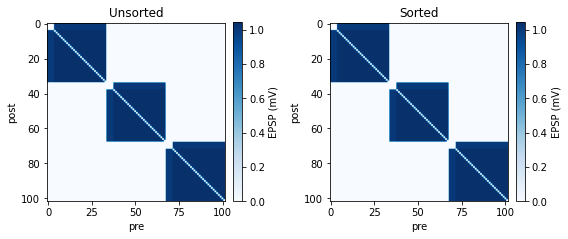

--------------------------------------------------------------------------------
T = 18.0 seconds


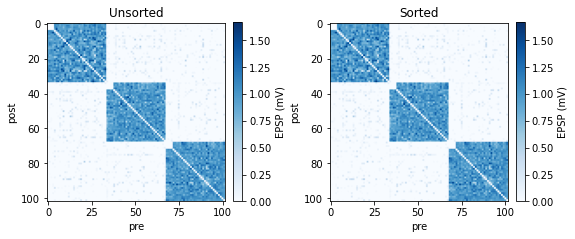

  2%|▏         | 1/50 [00:32<26:45, 32.77s/it]

--------------------------------------------------------------------------------
T = 36.0 seconds


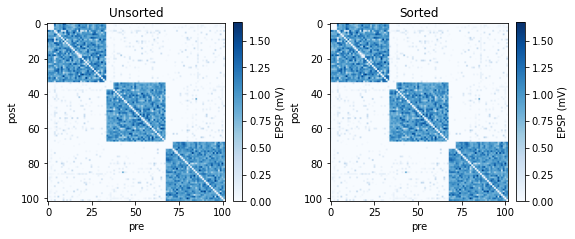

  4%|▍         | 2/50 [00:51<19:28, 24.34s/it]

--------------------------------------------------------------------------------
T = 54.0 seconds


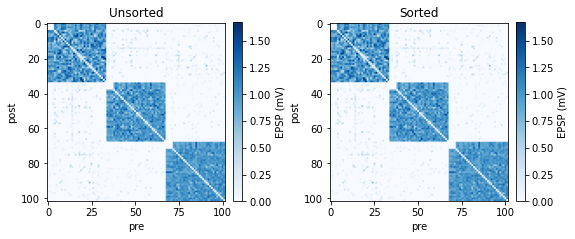

  6%|▌         | 3/50 [01:09<17:01, 21.74s/it]

--------------------------------------------------------------------------------
T = 72.0 seconds


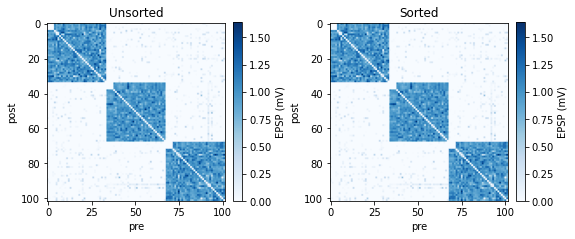

  8%|▊         | 4/50 [01:28<15:44, 20.53s/it]

--------------------------------------------------------------------------------
T = 90.0 seconds


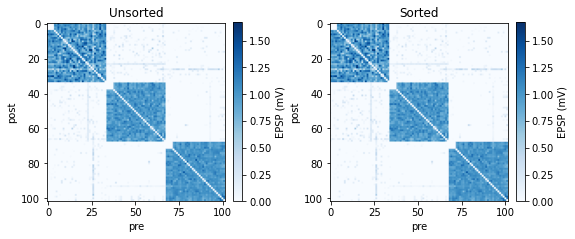

 10%|█         | 5/50 [01:46<14:49, 19.76s/it]

--------------------------------------------------------------------------------
T = 108.0 seconds


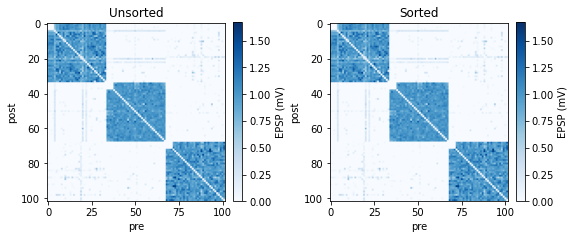

 12%|█▏        | 6/50 [02:05<14:10, 19.34s/it]

--------------------------------------------------------------------------------
T = 126.0 seconds


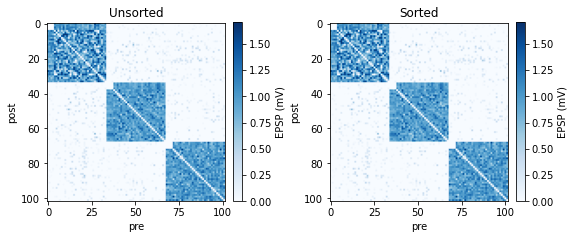

 14%|█▍        | 7/50 [02:23<13:37, 19.02s/it]

--------------------------------------------------------------------------------
T = 144.0 seconds


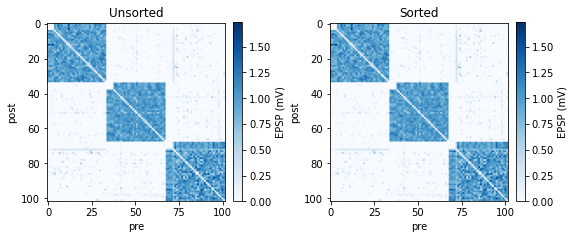

 16%|█▌        | 8/50 [02:41<13:07, 18.76s/it]

--------------------------------------------------------------------------------
T = 162.0 seconds


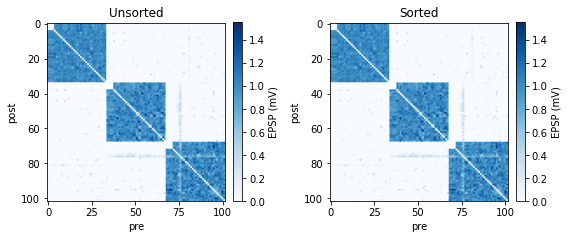

 18%|█▊        | 9/50 [03:00<12:44, 18.65s/it]

--------------------------------------------------------------------------------
T = 180.0 seconds


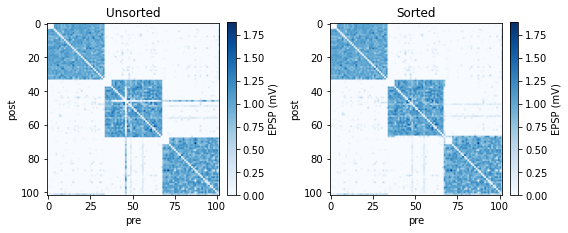

 20%|██        | 10/50 [03:18<12:21, 18.54s/it]

--------------------------------------------------------------------------------
T = 198.0 seconds


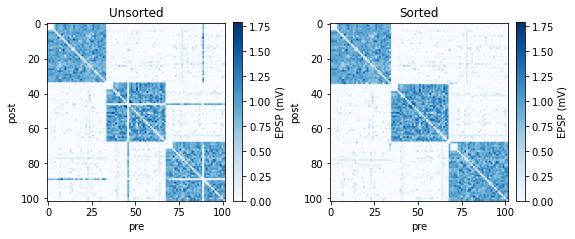

 22%|██▏       | 11/50 [03:37<12:00, 18.48s/it]

--------------------------------------------------------------------------------
T = 216.0 seconds


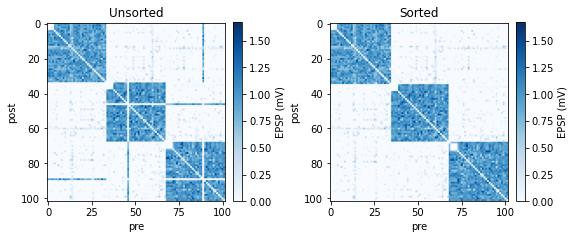

 24%|██▍       | 12/50 [03:55<11:41, 18.47s/it]

--------------------------------------------------------------------------------
T = 234.0 seconds


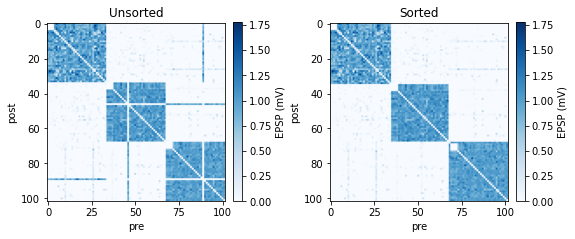

 26%|██▌       | 13/50 [04:13<11:23, 18.47s/it]

--------------------------------------------------------------------------------
T = 252.0 seconds


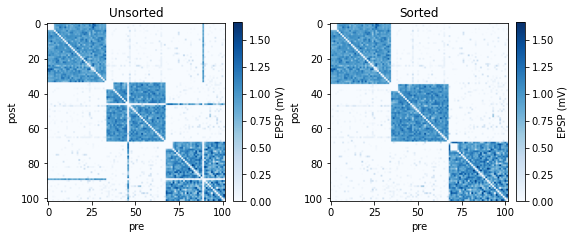

 28%|██▊       | 14/50 [04:32<11:03, 18.43s/it]

--------------------------------------------------------------------------------
T = 270.0 seconds


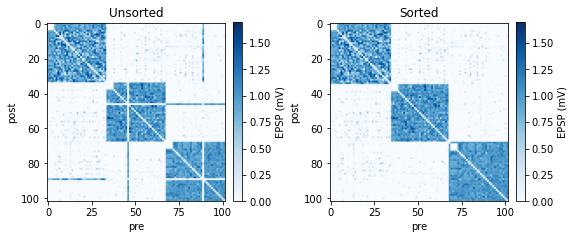

 30%|███       | 15/50 [04:50<10:44, 18.41s/it]

--------------------------------------------------------------------------------
T = 288.0 seconds


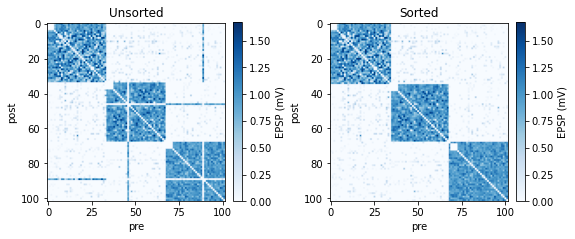

 32%|███▏      | 16/50 [05:09<10:26, 18.42s/it]

--------------------------------------------------------------------------------
T = 306.0 seconds


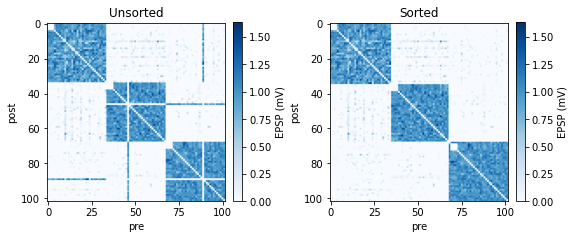

 34%|███▍      | 17/50 [05:27<10:12, 18.55s/it]

--------------------------------------------------------------------------------
T = 324.0 seconds


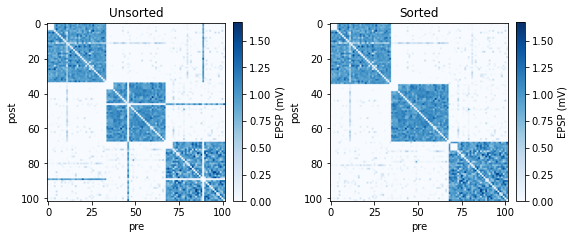

 36%|███▌      | 18/50 [05:46<09:57, 18.67s/it]

--------------------------------------------------------------------------------
T = 342.0 seconds


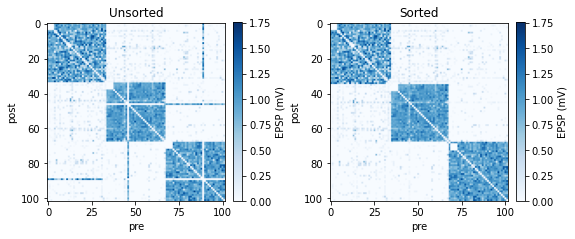

 38%|███▊      | 19/50 [06:06<09:47, 18.95s/it]

--------------------------------------------------------------------------------
T = 360.0 seconds


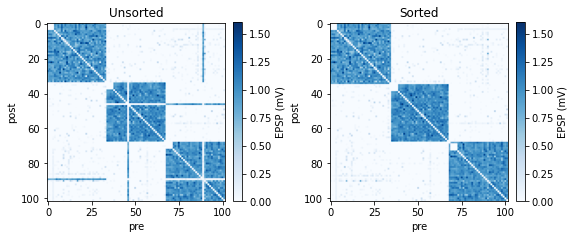

 40%|████      | 20/50 [06:25<09:29, 19.00s/it]

--------------------------------------------------------------------------------
T = 378.0 seconds


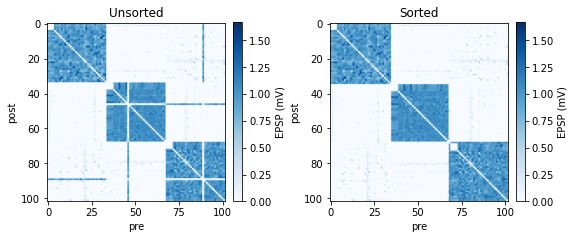

 42%|████▏     | 21/50 [06:44<09:07, 18.87s/it]

--------------------------------------------------------------------------------
T = 396.0 seconds


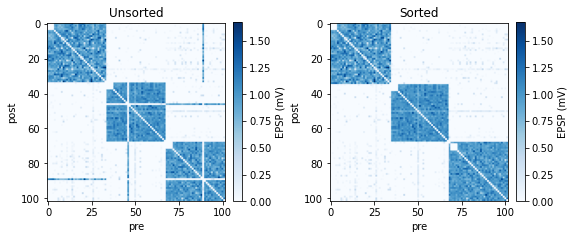

 44%|████▍     | 22/50 [07:03<08:47, 18.85s/it]

--------------------------------------------------------------------------------
T = 414.0 seconds


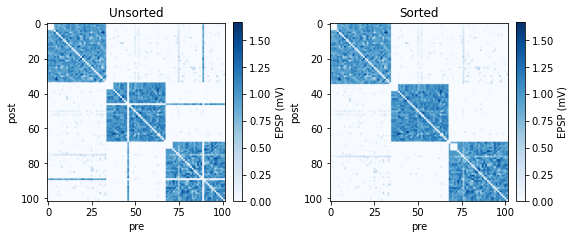

 46%|████▌     | 23/50 [07:21<08:24, 18.70s/it]

--------------------------------------------------------------------------------
T = 432.0 seconds


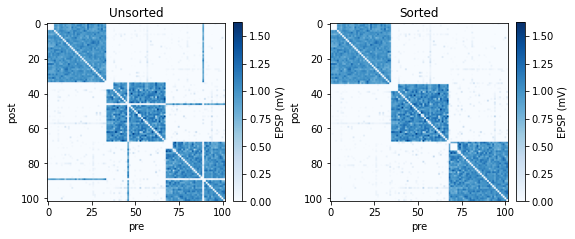

 48%|████▊     | 24/50 [07:39<08:05, 18.68s/it]

--------------------------------------------------------------------------------
T = 450.0 seconds


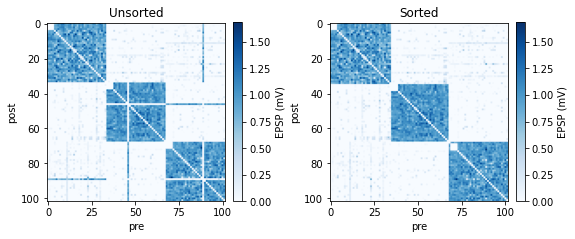

 50%|█████     | 25/50 [07:58<07:46, 18.66s/it]

--------------------------------------------------------------------------------
T = 468.0 seconds


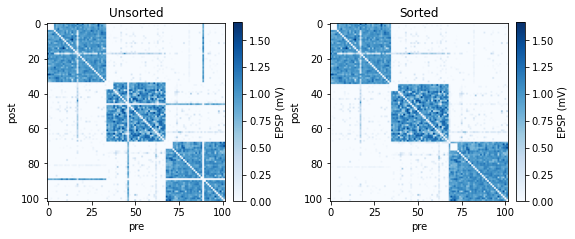

 52%|█████▏    | 26/50 [08:17<07:29, 18.73s/it]

--------------------------------------------------------------------------------
T = 486.0 seconds


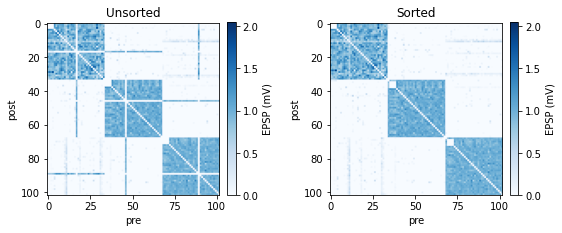

 54%|█████▍    | 27/50 [08:35<07:08, 18.64s/it]

--------------------------------------------------------------------------------
T = 504.0 seconds


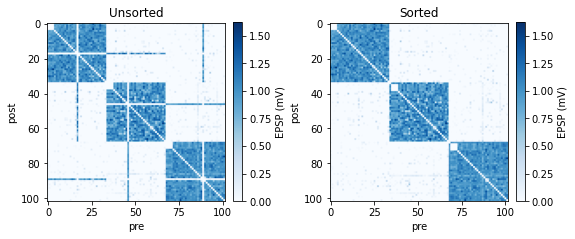

 56%|█████▌    | 28/50 [08:54<06:49, 18.63s/it]

--------------------------------------------------------------------------------
T = 522.0 seconds


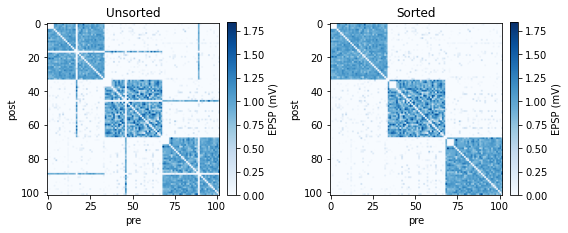

 58%|█████▊    | 29/50 [09:12<06:29, 18.57s/it]

--------------------------------------------------------------------------------
T = 540.0 seconds


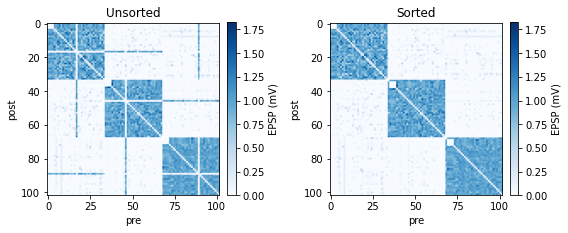

 60%|██████    | 30/50 [09:31<06:11, 18.58s/it]

--------------------------------------------------------------------------------
T = 558.0 seconds


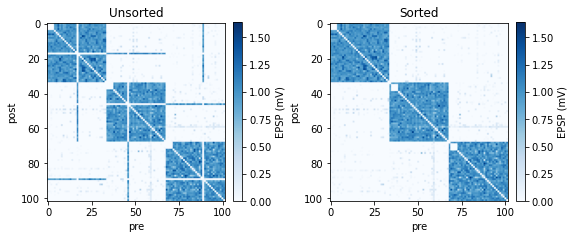

 62%|██████▏   | 31/50 [09:50<05:53, 18.59s/it]

--------------------------------------------------------------------------------
T = 576.0 seconds


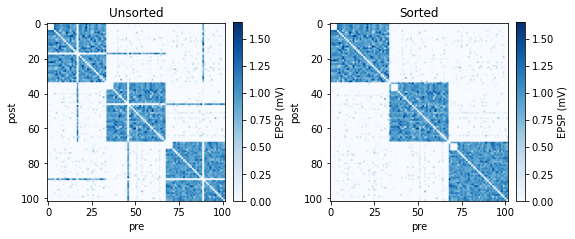

 64%|██████▍   | 32/50 [10:08<05:35, 18.62s/it]

--------------------------------------------------------------------------------
T = 594.0 seconds


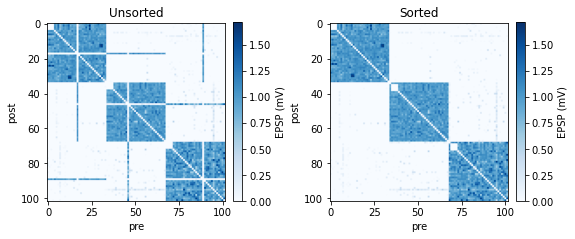

 66%|██████▌   | 33/50 [10:27<05:16, 18.63s/it]

--------------------------------------------------------------------------------
T = 612.0 seconds


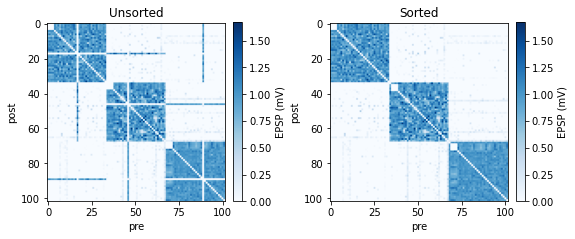

 68%|██████▊   | 34/50 [10:46<04:57, 18.61s/it]

--------------------------------------------------------------------------------
T = 630.0 seconds


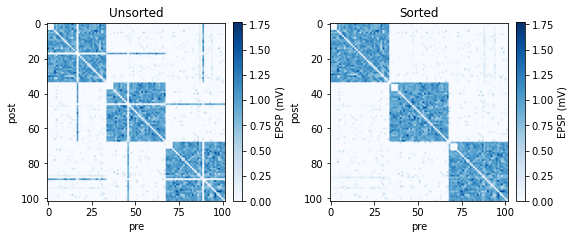

 70%|███████   | 35/50 [11:04<04:40, 18.69s/it]

--------------------------------------------------------------------------------
T = 648.0 seconds


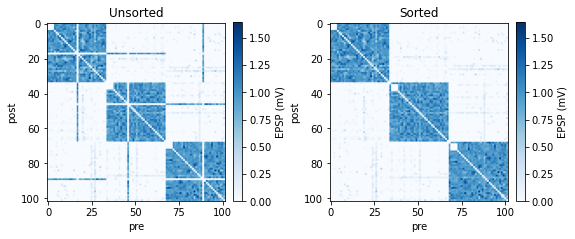

 72%|███████▏  | 36/50 [11:23<04:20, 18.63s/it]

--------------------------------------------------------------------------------
T = 666.0 seconds


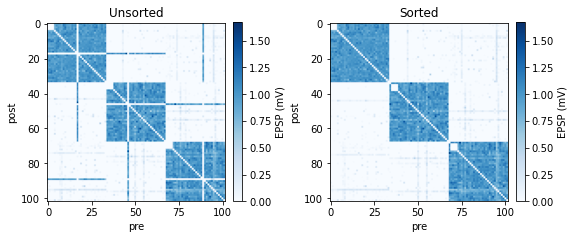

 74%|███████▍  | 37/50 [11:42<04:02, 18.64s/it]

--------------------------------------------------------------------------------
T = 684.0 seconds


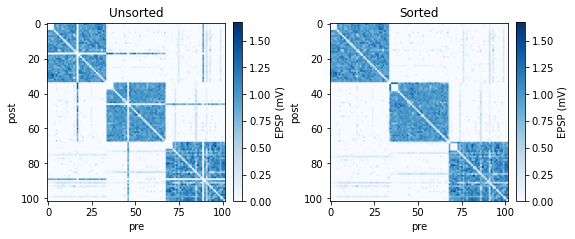

 76%|███████▌  | 38/50 [12:00<03:43, 18.61s/it]

--------------------------------------------------------------------------------
T = 702.0 seconds


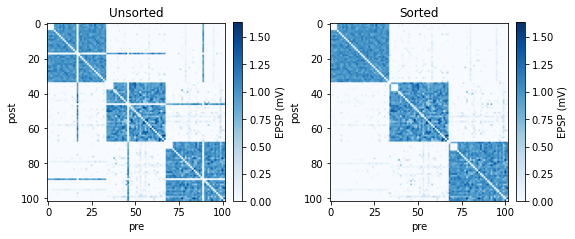

 78%|███████▊  | 39/50 [12:19<03:24, 18.58s/it]

--------------------------------------------------------------------------------
T = 720.0 seconds


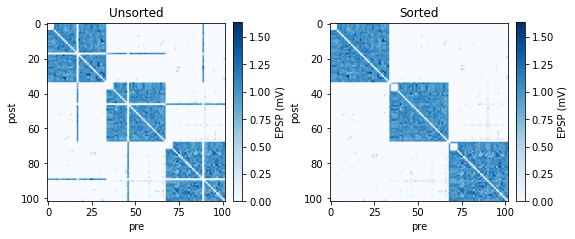

 80%|████████  | 40/50 [12:37<03:05, 18.60s/it]

--------------------------------------------------------------------------------
T = 738.0 seconds


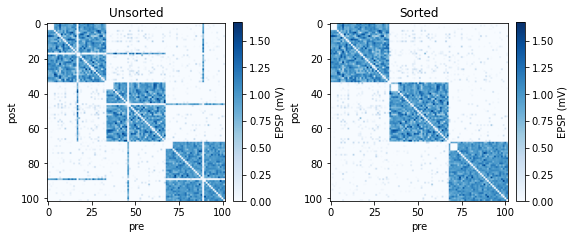

 82%|████████▏ | 41/50 [12:56<02:47, 18.60s/it]

--------------------------------------------------------------------------------
T = 756.0 seconds


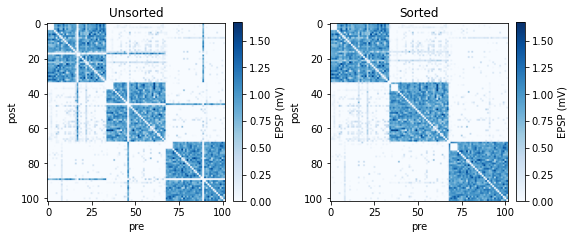

 84%|████████▍ | 42/50 [13:14<02:28, 18.56s/it]

--------------------------------------------------------------------------------
T = 774.0 seconds


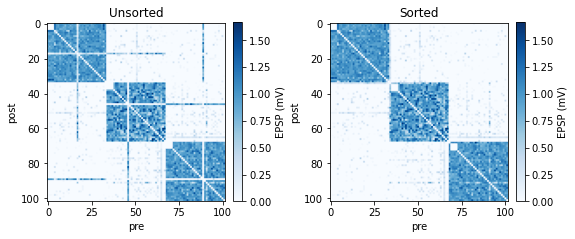

 86%|████████▌ | 43/50 [13:33<02:09, 18.56s/it]

--------------------------------------------------------------------------------
T = 792.0 seconds


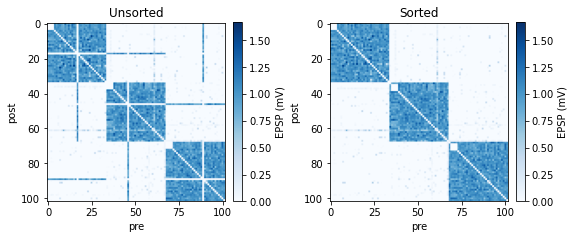

 88%|████████▊ | 44/50 [13:52<01:51, 18.61s/it]

--------------------------------------------------------------------------------
T = 810.0 seconds


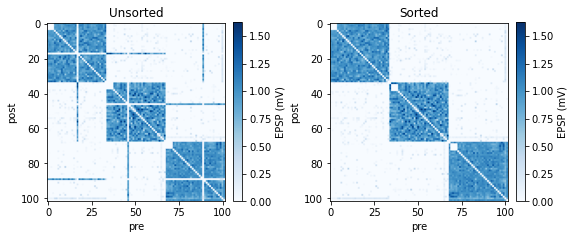

 90%|█████████ | 45/50 [14:10<01:32, 18.56s/it]

--------------------------------------------------------------------------------
T = 828.0 seconds


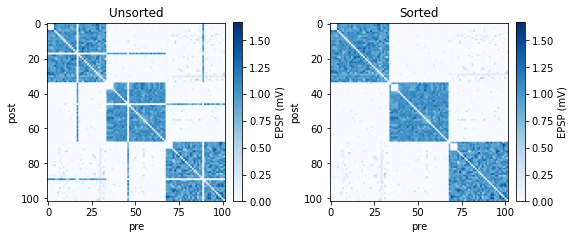

 92%|█████████▏| 46/50 [14:29<01:14, 18.61s/it]

--------------------------------------------------------------------------------
T = 846.0 seconds


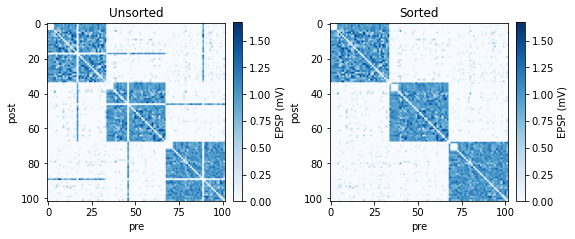

 94%|█████████▍| 47/50 [14:48<00:56, 18.69s/it]

--------------------------------------------------------------------------------
T = 864.0 seconds


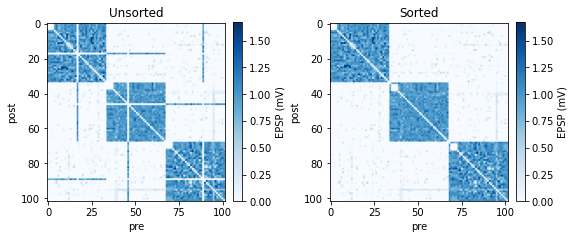

 96%|█████████▌| 48/50 [15:06<00:37, 18.68s/it]

--------------------------------------------------------------------------------
T = 882.0 seconds


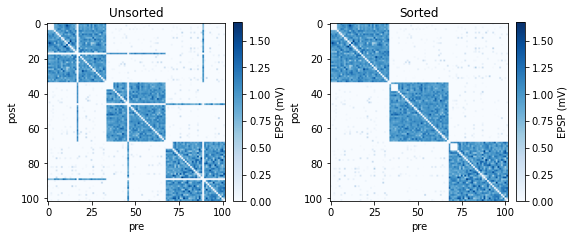

 98%|█████████▊| 49/50 [15:25<00:18, 18.66s/it]

--------------------------------------------------------------------------------
T = 900.0 seconds


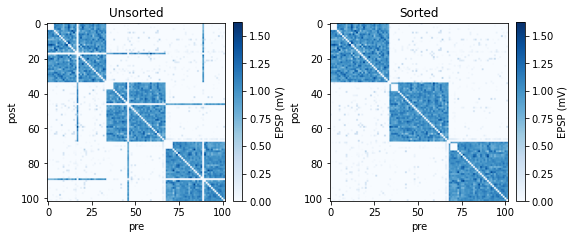

100%|██████████| 50/50 [15:44<00:00, 18.88s/it]

Finished Simulation


In [13]:
net.restore()  # restore initial network state
# Run network
print("Start simulation")
for intv in tqdm(range(intvs_n)):
    if intv == 0:
        L_init = report_weights(S_ee)
    for mon in M_list:
        mon.active = True
    net.run(M_t)
    for mon in M_list:
        mon.active = False
    net.run(intvs_t - M_t)
    L_init = report_weights(S_ee, L_init)
M_see.record_single_timestep()
print("Finished Simulation")

# Results

Let's take a closer look at the spiking activity, the membrane potential of one of the neurons, the adjancy matrix and the weight matrices. The periphery neurons and the connections involving periphery neurons are highlighted in different colors depending to which assembly they belonged to at the start of the simulation.

In [14]:
colors = ["Reds", "Greens", "Purples"]  # colors of periphery neurons
periphery_ind = np.arange(N_e)[np.arange(N_e) % asbly_size < N_peri]
periphery_ind = periphery_ind.reshape(
    (asbly_n, N_peri)
)  # indices of periphery neurons

In [15]:
# Plot weight matrices
def plot_matrices(Syn, M_syn_w, intvs, adj = False, ordered=False, title=None):

    n_intvs = len(intvs)

    fig, axs = plt.subplots(1, n_intvs, figsize=(n_intvs * 4, 4))
    W = np.zeros((N_e, N_e))
    for i, intv in enumerate(intvs):
        ax = axs[i]
        W[Syn.i[:], Syn.j[:]] = w_to_epsp * M_syn_w[:, intv].T / mV
        sorted_ind = np.arange(N_e)
        if ordered:
            L, _ = bct.community_louvain(W, 1, None)
            sorted_ind = np.concatenate(
                [np.where(L == i + 1)[0] for i in range(L.max())]
            )
            W = W[:, sorted_ind]
            W = W[sorted_ind, :]
        im = ax.imshow(W, cmap="Blues")
        if not adj:
            fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label='EPSP (mV)')

        for j in range(asbly_n):
            periphery_ind_sorted = np.where(
                np.in1d(sorted_ind, periphery_ind[j]) == True
            )[0]
            mask_p = np.ones_like(W)
            mask_p[periphery_ind_sorted, :] = 0
            mask_p[:, periphery_ind_sorted] = 0
            W_p = np.ma.masked_array(W, mask_p)
            ax.imshow(W_p, cmap=colors[j])

        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("pre")
        ax.set_ylabel("post")
        ax.set_title("T=" + str(intv * intvs_t))

    fig.suptitle(title, fontsize=15)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.show()

In [16]:
# Plot spikes and membrane potential
def plot_spikesandpot(intvs):

    n_intvs = len(intvs)

    fig, axs = plt.subplots(
        2,
        n_intvs,
        sharex="col",
        sharey="row",
        figsize=(4 * n_intvs, 4),
        gridspec_kw={"height_ratios": [3, 1]},
    )

    # Prepare Spikes
    fig_events = []
    fig_cols = []
    for i in range(N_e):
        fig_events.append(M_e_spikes.t[M_e_spikes.i == i])
        if i in periphery_ind:
            fig_cols.append(colors[np.where(periphery_ind == i)[0][0]][:-1])
        else:
            fig_cols.append("C0")
    for i in range(N_i):
        fig_events.append(M_i_spikes.t[M_i_spikes.i == i])
        fig_cols.append("k")

    # Prepare potential
    fig_vs = M_e_states.v[0].copy()
    spike_idxs = (
        M_e_spikes.t[M_e_spikes.i == 0] % intvs_t
        + (M_e_spikes.t[M_e_spikes.i == 0] // intvs_t) * M_t
    )
    spike_idxs = (spike_idxs / defaultclock.dt).astype(int)
    fig_vs[spike_idxs] = 100 * mV

    for i, intv in enumerate(intvs):

        # Spikes
        ax = axs[0, i]
        ax.eventplot(fig_events, colors=fig_cols)
        ax.set_ylim(0, N_e + N_i)
        if i == 0:
            ax.set_ylabel(r"$i$")

        # Potential
        ax = axs[1, i]
        ax.plot(M_e_states.t, fig_vs)
        ax.axhline(v_th / volt, c="k", lw=1)
        ax.axhline(v_0 / volt, c="k", lw=1)
        ax.set_xlim(intv * intvs_t / second, (intv * intvs_t + M_t) / second)
        ax.set_ylim((v_0 - 5 * mV) / volt, 1.5 * v_th / volt)
        ax.set_yticks([v_0 / volt, v_th / volt])
        ax.set_yticklabels([r"$V_0$", r"$V_\theta$"])
        ax.set_xlabel("t (s)")
        if i == 0:
            ax.set_ylabel(r"$V_5$")

    fig.tight_layout()
    plt.show()

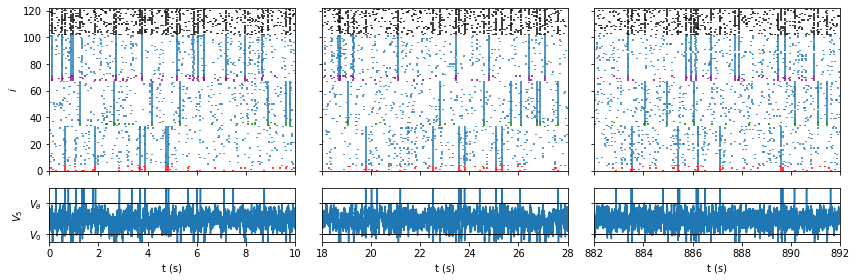

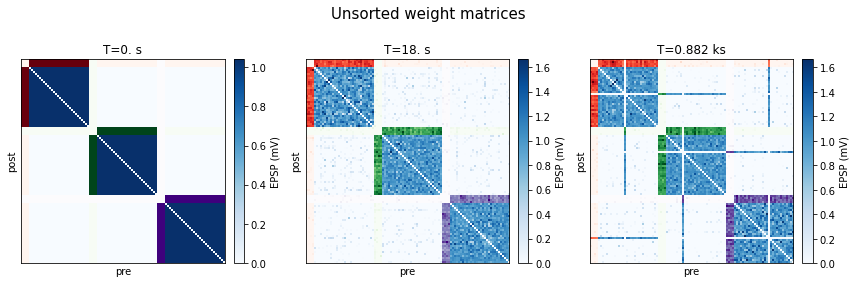

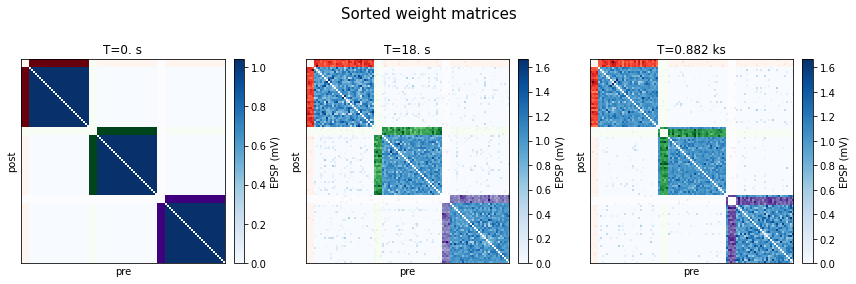

In [17]:
plot_intvs = [0, 1, intvs_n-1]  # Plotting intervals
plot_spikesandpot(plot_intvs)
plot_matrices(
    S_ee,
    M_see.w,
    plot_intvs,
    title="Unsorted weight matrices",
)
plot_matrices(
    S_ee,
    M_see.w,
    plot_intvs,
    ordered=True,
    title="Sorted weight matrices",
)